In [2]:
# libs 
import numpy as np 
import cv2 
import pandas as pd 
import matplotlib.pyplot as plt 
import os 

/home/anirudh/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
# get data from the BMPD_Db
dest_f = "BMPD_db"
for files in os.listdir(dest_f):
    sub_f = dest_f+"/"+files
    for file in os.listdir(sub_f):
        file_loc = sub_f+"/"+file
        img = cv2.imread(file_loc,0)
        #plt.imshow(img,cmap = 'gray')
    break

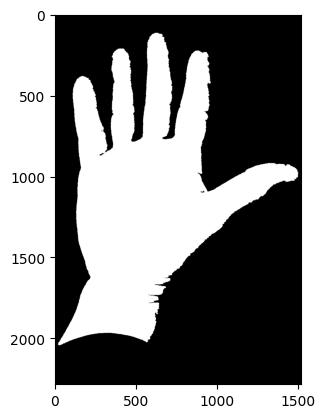

In [4]:
img1 = img.copy()

from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion, binary_dilation, disk
from skimage.segmentation import clear_border

# Threshold the image using Otsu's method
thresh = threshold_otsu(img1)
binary = img1 > thresh

# Remove the border and fill holes in the binary image
border = binary_erosion(binary, disk(3))
border = clear_border(border)
filled = binary_dilation(border, disk(5))

# Invert the binary image to get the mask
mask = np.logical_not(filled)

# Display the mask
plt.imshow(filled, cmap='gray')
plt.show()

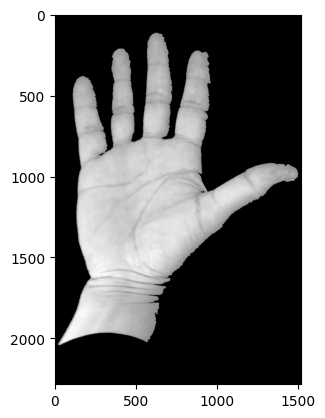

In [5]:
masked_img = cv2.bitwise_and(img, img, mask= np.uint8(filled)*255)
plt.imshow(masked_img,cmap = 'gray')

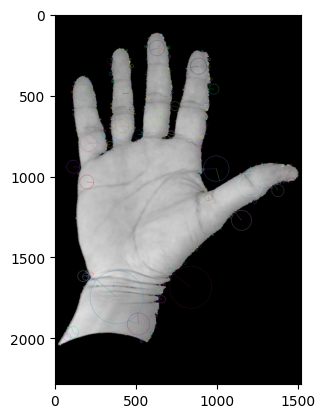

In [9]:
# Create SIFT object
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
kp, des = sift.detectAndCompute(masked_img, None)

# Draw keypoints on the original image
img_with_kp = cv2.drawKeypoints(masked_img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


plt.imshow(img_with_kp,cmap = 'gray')


In [12]:
def histogram_of_oriented_lines(gray_image, num_bins=9, cell_size=(8, 8), block_size=(2, 2)):
    # gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gx = cv2.Sobel(gray_image, cv2.CV_32F, 1, 0, ksize=1)
    gy = cv2.Sobel(gray_image, cv2.CV_32F, 0, 1, ksize=1)
    magnitude, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)

    angle_bins = np.arange(0, 360, 360 / num_bins)
    angle_quantized = np.digitize(angle, angle_bins) % num_bins

    h, w = gray_image.shape
    num_cells_y = h // cell_size[0]
    num_cells_x = w // cell_size[1]

    histograms = np.zeros((num_cells_y, num_cells_x, num_bins))

    for i in range(num_cells_y):
        for j in range(num_cells_x):
            cell_angle = angle_quantized[i * cell_size[0]:(i + 1) * cell_size[0], j * cell_size[1]:(j + 1) * cell_size[1]]
            cell_magnitude = magnitude[i * cell_size[0]:(i + 1) * cell_size[0], j * cell_size[1]:(j + 1) * cell_size[1]]

            for k in range(num_bins):
                histograms[i, j, k] = np.sum(cell_magnitude[cell_angle == k])

    num_blocks_y = num_cells_y - block_size[0] + 1
    num_blocks_x = num_cells_x - block_size[1] + 1

    normalized_histograms = np.zeros((num_blocks_y, num_blocks_x, block_size[0] * block_size[1] * num_bins))

    for i in range(num_blocks_y):
        for j in range(num_blocks_x):
            block_histogram = histograms[i:i + block_size[0], j:j + block_size[1], :].flatten()
            normalized_histograms[i, j, :] = block_histogram / np.sqrt(np.sum(block_histogram ** 2) + 1e-6)

    return normalized_histograms.flatten()



In [21]:
# Example usage
image = masked_img
hol_descriptor = histogram_of_oriented_lines(image)

In [22]:
print(hol_descriptor)

[0. 0. 0. ... 0. 0. 0.]


In [23]:
hol_descriptor.shape

(1932336,)

In [24]:
img.shape

(2284, 1521)

In [25]:
def visualize_hol(gray_image, hol_descriptor, cell_size=(8, 8), num_bins=9):
    # gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    h, w = gray_image.shape

    num_cells_y = h // cell_size[0]
    num_cells_x = w // cell_size[1]

    max_val = np.amax(hol_descriptor)
    descriptor_normalized = hol_descriptor.reshape(num_cells_y - 1, num_cells_x - 1, -1) / max_val

    angle_step = 360 // num_bins
    radius = min(cell_size) // 2 - 1

    visualization = np.zeros((h, w), dtype=np.uint8)
    for i in range(num_cells_y - 1):
        for j in range(num_cells_x - 1):
            for k in range(num_bins):
                angle = (k * angle_step + angle_step // 2) * np.pi / 180
                magnitude = descriptor_normalized[i, j, k] * max_val * 100
                pt1 = (j * cell_size[1] + cell_size[1] // 2, i * cell_size[0] + cell_size[0] // 2)
                pt2 = (int(pt1[0] + radius * magnitude * np.cos(angle)), int(pt1[1] - radius * magnitude * np.sin(angle)))
                cv2.line(visualization, pt1, pt2, 255, 1)

    return visualization



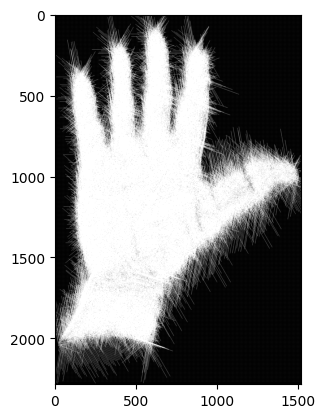

In [26]:
# Example usage
visualization = visualize_hol(image, hol_descriptor)

plt.imshow(visualization, cmap='gray')
plt.show()